In [ ]:
! pip install --quiet --upgrade --user google-cloud-aiplatform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 22.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
# A notebook's kernel restart may be required to ensure package installation.

import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [5]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [6]:
import random

from typing import Any
from pydantic import BaseModel, Field

import google.generativeai as genai
import vertexai
from vertexai.preview.vision_models import ImageGenerationModel, GeneratedImage

In [7]:
# Enter details here
info = {"PROJECT_ID": "", "LOCATION" : "", "API_KEY" : ""}

In [30]:
class BannerGenerator(BaseModel):
  """This class will be responsible for endpoints related to Image Generation mechanism"""

  CONFIGS: dict
  topic: str
  images: list | None = Field(default=None)
  text_model: str = "gemini-1.5-flash"
  image_model: str = "imagen-3.0-generate-001"
  # image_model: str = "imagen-3.0-fast-generate-001"
  pm: Any = None
  im: Any = None
  text_v0: str = None
  text_v1: str = None
  text_v2: str = None
  text_v3: str = None
  img_response: Any = None

  def __launch(self):
    vertexai.init(project=self.CONFIGS['PROJECT_ID'], location=self.CONFIGS['LOCATION'])
    genai.configure(api_key = self.CONFIGS['API_KEY'])
    self.pm = genai.GenerativeModel(self.text_model)
    self.im = ImageGenerationModel.from_pretrained(self.image_model)

  def extract_information(self):

    self.__launch()

    # Information Gathering
    out_text = f"""Deep analyze text from retail advertising, marketing psychology and thoroughly researched marketing studies perspective: {self.topic}
    Extract the following information:
    0. Product: Product name, brand, supplier, if available.
    1. Objective: 1 word for primary goal of the banner. Example - Awareness, Engagement, Conversion, Branding
    2. Age: The target age group. Example - 'Below 18', '18-25', '25-40', '40-60', '60+'
    3. Gender: Gender preference if applicable. Example - MALE, FEMALE, NON BINARY, ALL
    4. Festival: Event or occasion it may be tied to. Example - Christmas, Diwali, Black Friday, Summer Sale, New Year, Generic
    5. Headline: Suggest a main text that captures attention. Example - Discover [product] for [festival], Shop now and save!, Limited time offer, Innovate your life with [product]
    6. Subheadline: Optional additonal supporting information to clarify the offer. Example - Get 50% off until [date], Exclusive deal for festive season, Hurry offer ends soon
    7. CTA: Add a call to action. Example - Buy now, Shop the collection, Discover More, Sign up today
    8. Color Scheme: Use color palette based on audience, occasion, or product tone. Example - Red & Gold (Festive, Urgency), Blue & White (Trust, Calm), Green & Brown (Eco-friendly, Natural), Black & White (Elegant, Minimal)
    9. Typography: Use font styles that resonate with the target demographic. Example - Sans-serif (Modern, Youthful), Serif (Traditional, Trustworthy), Script (Elegant, Formal), Display fonts (Playful, Bold)
    10. Visual Layout: Use layout pattern to guide user attention. Example - F pattern (Text-heavy), Z pattern (Balanced visuals & text)
    11. Imagery: Use of product images and contextual photos. If provided reuse them else create own. Examples - Multiple product angles, Lifestyle imagery, Holiday-themed images, Close-up product features
    12. Branding: Ensure logo placement and brand consistency. Top-left for logo, Consistent brand colors, Brand slogan or tagline inclusion
    13. Emotional Appeal: Emotion that the banner evokes based on psychographics and event. Example - Nostalgia (Older audiences, festive), Excitement (Younger audiences, sales), Trust and reliability (Product-focused), Aspiration (Luxury goods)
    14. Adaptability: Optionally, ensure banner scales well on mobile and other devices. Example - Mobile-first design, Large, clear CTA, Minimal text for mobile
    15. Psychographics: Tailor the banner’s design, tone, and visuals based on psychographic factors and set levels for suitable OCEAN traits applicable. Example - [High/Low Openness (Innovation, Creativity): Innovative, creative visuals], [High/Low Conscientiousness (Order, Reliability): Clean, organized layout], [High/Low Extraversion (Vibrancy, Sociability): Bold colors, active themes], [High/Low Agreeableness (Warmth, Trust): Soft tones, community appeal], [High/Low Neuroticism (Stability, Reassurance)]
    16. Region: Location if applicable. Example - USA, London, India, Generic
    17. Specifications: Summarize restrictions on output quality, content and format, if applicable.
    18. Ethnicity: Identify population group.

    Capture/modify any relevant extra information from your analysis in above respective buckets or extra buckets if needed.
    """
    self.text_v0 = self.pm.generate_content(out_text).text

    # Information consolidation
    out_text = f"Respond concisely and summarize in python dictionary format only this: {self.text_v0}"
    self.text_v1 = self.pm.generate_content(out_text).text[9:-5]

    # Scrapper
    out_text = f"Respond concisely by scrapping all unavailable information in python dictionary format only this: {self.text_v1}"
    self.text_v2 = self.pm.generate_content(out_text).text

  # TODO: Extract more relevant information from product images
  def extract_image_information(self):
    pass

  def create_text_prompt(self):

    out_text = f"""Task: Write comma separated summarized prompt for: {self.text_v2}
    Guidelines:
    It will be used to generate an ads banner.
    Ensure it has all details meticulously captured.
    All unknown/missing/unprovided variables are replaced with the attributes of most probable shopper for that product.
    Recheck and identify all ambiguity or any text that leads to uncertainty.
    Replace all uncertainty with solid and targeted values that make most sense for given product.
    Quantify all high medium and lows with appropriate values based on marketing research studies.
    Remove any details about statistical testing or names of any performance KPIs.
    Avoid sentences and use only necessary keywords.
    Remove redundant words.
    Summarize in less than 150 words.
    """
    self.text_v3 = self.pm.generate_content(out_text).text

  def generate_image(self):
    prompt = f"""Realistic high quality ad capturing every detail for :{self.text_v3}"""
    self.img_response = self.im.generate_images(prompt=prompt)

    #TODO: Product images as input

  # TODO: Brand, background, logo, discount, headlines and subheadlines through gemini
  def identify_lags(self):
    pass

  # TODO: Image editing through imagen
  def fix_image(self):
    pass

  def display(self):
    print("="*100)
    print(f"Prompt v0: {self.text_v0}")

    print("="*100)
    print(f"Prompt v1: {self.text_v1}")

    print("="*100)
    print(f"Prompt v2: {self.text_v2}")

    print("="*100)
    print(f"Prompt v3: {self.text_v3}")

    print("="*100)
    self.img_response.images[0].show()

Prompt v0: ## Deep Analysis of "Fresh Lentils for Europe on 15% Discount" Retail Banner

Here's a breakdown of the banner based on the provided information and marketing principles:

**0. Product:**

* **Product Name:** Fresh Lentils
* **Brand:**  Not specified (could be a store brand or a specific lentil producer)
* **Supplier:** Not specified

**1. Objective:** Conversion

**2. Age:**  25-60+ (Lentils appeal to a wide range, but the discount might target those seeking value)

**3. Gender:** ALL

**4. Festival:** Generic (no specific event mentioned)

**5. Headline:** 

* **Option 1:**  "Fresh Lentils: 15% Off for Europe!" (Direct and informative)
* **Option 2:**  "Fuel Your Meals with 15% Off Fresh Lentils!" (Appeals to health and culinary use) 

**6. Subheadline:**  "Limited Time Offer. Shop Now and Save!"

**7. CTA:**  "Shop Now"

**8. Color Scheme:**

* **Option 1:** Green & Brown (Eco-friendly, natural, associated with lentils)
* **Option 2:** Orange & Yellow (Warm, inviting, sug

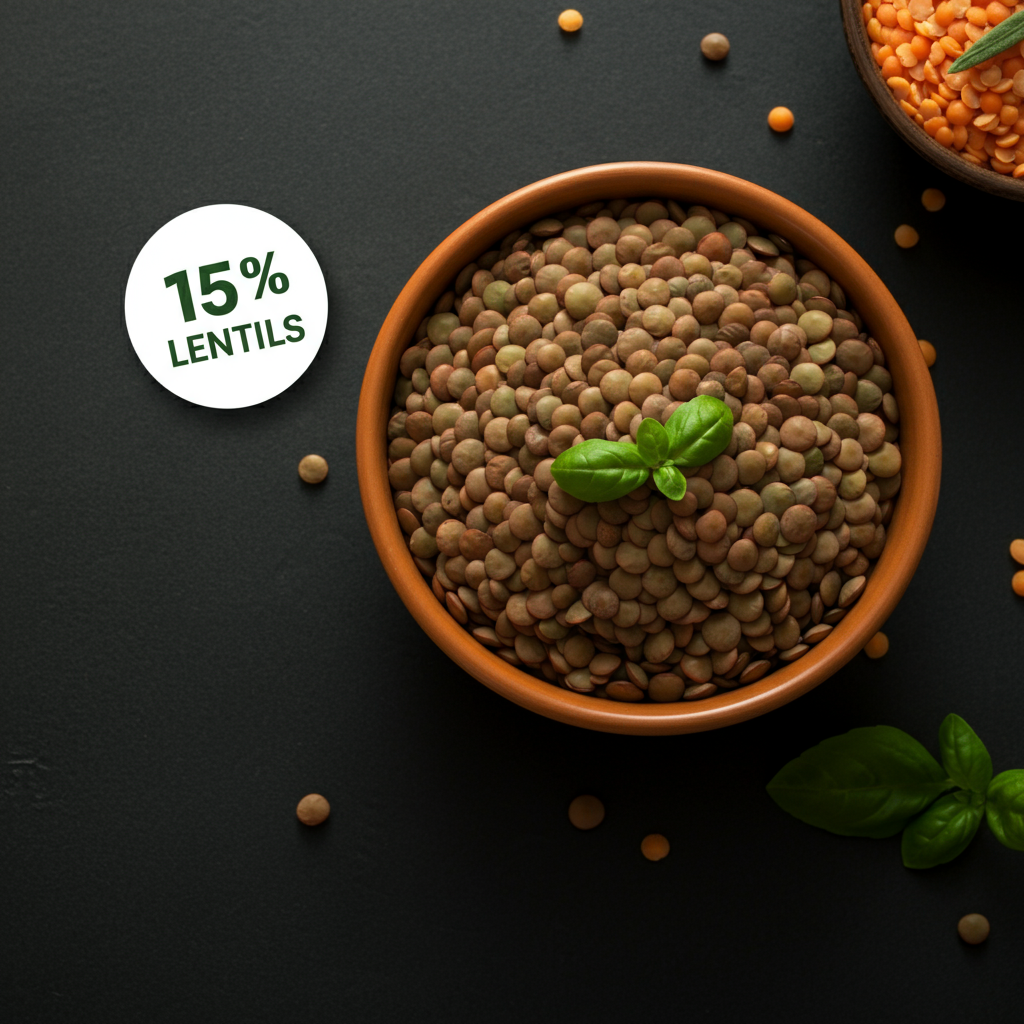

In [31]:
obj = BannerGenerator(CONFIGS = info, topic = "fresh lentils for europe on 15% discount")
obj.extract_information()
obj.create_text_prompt()
obj.generate_image()
obj.display()